In [424]:
import pandas as pd
!pip install ace_tools
import itertools


In [1137]:
import test_local
print(dir(test_local))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [1085]:
import pandas as pd
import numpy as np
k=6
r=100


datairline = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta").set_index("market")
coldatairline = datairline.shape[1]
X = datairline.iloc[:, k:]

colX = X.shape[1]               
y = datairline.iloc[:, :k]           
rowX = X.shape[0] 

param =[-1,1,1,1,1,1,1,1,1,1,1,-3,-3,-3,-3,-3,-3]
constant = param[0]  # 定数項
paramX = param[1:9]      # 外生変数
paraheterog1 = param[9]  # 異質性1
paraheterog2 = param[10] # 異質性2
parafirm1 = param[11:17] # 競合効果


roleX = X.iloc[:, :8] @ paramX
roleX = np.tile(roleX.to_numpy().reshape(-1, 1), (1, k))

roleheter = X.iloc[:, 8:14].to_numpy() * paraheterog1
roleheter += X.iloc[:, 14:20].to_numpy() * paraheterog2

index = list(itertools.product([0, 1], repeat=k))
index = np.array(index)  # ⬅️ NumPy配列に変換
total = index.shape[0]


onothereffect = np.zeros((total * X.shape[0], k))
repindex = np.tile(index, (X.shape[0], 1))

for i in range(k):
    effect = repindex[:, i:i+1] * parafirm1[i]
    effect = np.tile(effect, (1, k))
    effect[:, i] = 0  # 自分自身の影響は除外
    onothereffect += effect

owneffect = np.ones((total, k)) * constant


repi_roleX = np.repeat(roleX, repeats=2 ** k, axis=0)


repi_roleheter = np.repeat(roleheter, repeats=2 ** k, axis=0)


repi_owneffect = np.repeat(owneffect, repeats=rowX, axis=0)



common = repi_owneffect + repi_roleheter + repi_owneffect


In [679]:
sumupp = np.zeros((rowX, total))
sumlow = np.zeros((rowX, total))

totcount = r * np.ones((rowX, 1))
temp = np.zeros((rowX, 1))

In [680]:
epsitemp = np.random.normal(loc=0.0, scale=0.4, size=rowX * k).reshape(rowX, k)
epsitemp = np.repeat(epsitemp, repeats=2 ** k, axis=0)
epsitemp = epsitemp*repindex

equil = epsitemp + common  
equil = ((equil>=0).astype(int) == repindex).astype(int)
sumequil = np.sum(equil, axis=1)

In [952]:
# vectorequil.shape = (rowX * total, 1)
cumsumvectorequil = np.cumsum(vectorequil)

# 各市場の構造セットの末尾（totalごと）を取得
sumvectorequil = cumsumvectorequil[total - 1::total].reshape(-1, 1)

# 差分で「各市場ごとの均衡数」を得る
if sumvectorequil.shape[0] > 1:
    sumvectorequil[1:] = np.diff(sumvectorequil, axis=0)


In [1107]:
r = 100
k = 6

datairline = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta").set_index("market")
coldatairline = datairline.shape[1]
X = datairline.iloc[:, k:]

colX = X.shape[1]               
y = datairline.iloc[:, :k]           
rowX = X.shape[0] 

param =[-1,1,1,1,1,1,1,1,1,1,1,-2,-5,-5,-5,-3,-3]

paraconstant = param[0]
paramX = param[1:9]
paraheterog1 = param[9]
paraheterog2 = param[10]
parafirm1 = param[11:17]

roleX = X.iloc[:, :8] @ paramX
roleX = np.tile(roleX.to_numpy().reshape(-1, 1), (1, k))

roleheter = X.iloc[:, 8:14].to_numpy() * paraheterog1
roleheter += X.iloc[:, 14:20].to_numpy() * paraheterog2

index = list(itertools.product([0, 1], repeat=k))
index = np.array(index)  # ⬅️ NumPy配列に変換
total = index.shape[0]


onothereffect = np.zeros((total * X.shape[0], k))
repindex = np.tile(index, (X.shape[0], 1))

for i in range(k):
    effect = repindex[:, i:i+1] * parafirm1[i]
    effect = np.tile(effect, (1, k))
    effect[:, i] = 0  # 自分自身の影響は除外
    onothereffect += effect


owneffect = np.ones((total, k)) * constant


repi_roleX = np.repeat(roleX, repeats=2 ** k, axis=0)


repi_roleheter = np.repeat(roleheter, repeats=2 ** k, axis=0)


repi_owneffect = np.repeat(owneffect, repeats=rowX, axis=0)



common = repi_owneffect + repi_roleheter + onothereffect + repi_roleX


m=rowX
epsi = np.random.normal(0,1,m*k*r).reshape(m,k*r)
meanlow, meanupp, temp = simuloop(common,m,k,r,epsi,repindex)

sand_matrix = np.where(
    prob[:rowX, :] > meanupp,
    (prob[:rowX, :] - meanupp)**2,
    0
    ) + np.where(
    prob[:rowX, :] < meanlow,
    (prob[:rowX, :] - meanlow)**2,
    0
    )


neverpure = np.min(np.isfinite(meanupp), axis=1)
findneverpure = np.where(neverpure == 0)[0]
if findneverpure.size > 0:
    sand_matrix = np.delete(sand_matrix, findneverpure, axis=0)

    # (8b) 最終的な目的関数値

sand

69.46187614097005

In [1109]:
temp

0.0

In [1087]:
sand

2712.7261549440022

In [1088]:
epsi

array([[-0.01337112, -0.16941508, -0.79899802, ..., -0.57495291,
        -1.65754941, -1.76166082],
       [ 0.10309189,  0.50729191,  0.02501056, ..., -2.36426709,
        -0.88372689, -0.03261999],
       [ 1.19242533, -0.54538449,  0.95097319, ...,  0.0913684 ,
        -0.42829933, -1.27909086],
       ...,
       [-0.4325977 , -1.86133972, -0.71048022, ..., -0.13740077,
        -0.64740327, -0.05958329],
       [-0.86538209,  0.55569474, -0.29900997, ..., -0.82036187,
         1.13741549,  0.79065163],
       [ 0.3791659 , -0.13211334, -0.80367836, ..., -0.44456348,
         0.64059484, -1.2335481 ]])

In [1008]:
meanupp.shape

(2742, 64)

In [1033]:
sand_matrix = np.where(
    prob[:rowX, :] > meanupp,
    (prob[:rowX, :] - meanupp)**2,
    0
    ) + np.where(
    prob[:rowX, :] < meanlow,
    (prob[:rowX, :] - meanlow)**2,
    0
    )


In [1126]:
#初期値の読み込み
param_lines = []
with open('/Users/user/Desktop/replication/5368_data and programs_0/start_values.txt') as f:
    sim_num = str(int(f.readline().strip()))  # 1行目：sim_num
    for line in f:
        param_lines.extend([float(x) for x in line.strip().split()])

datairline = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta").set_index("market")
k = 6
r = 100
total = 2**k
    #説明変数と目的変数の獲得
X = datairline.iloc[:, k:]
y = datairline.iloc[:, :k] 

#マーケット数とカラム数の獲得          
rowX = X.shape[0] 
colX = X.shape[1]



'1'

In [1125]:
param0 

array([  1.3714,   0.5686,  -0.6776,   0.2736,   0.2042,   0.2962,
         0.983 , -13.3598,  -0.3217,  12.131 ,  -0.7806,  -9.5423,
        -9.0561,  -6.5715, -10.2389, -15.4918, -11.9097])

In [1040]:
def generate_random_prob(rowX=2742, k=6):
    num_structures = 2 ** k  # 2^k 通りの参入構造

    # ランダムな非負値を生成してから、行ごとに正規化（合計1）
    raw = np.random.rand(rowX, num_structures)
    prob = raw / raw.sum(axis=1, keepdims=True)

    return prob

# 例: 使用
prob = generate_random_prob()
print(prob.shape)  # (100, 8)
print(prob[0]) 

(2742, 64)
[0.00468551 0.00629758 0.00367664 0.012303   0.01877722 0.01240937
 0.02003066 0.02595366 0.02319822 0.0288849  0.00346524 0.02401404
 0.00863344 0.02753008 0.01171728 0.00719037 0.00948059 0.01799681
 0.00423367 0.00169862 0.00240419 0.01318267 0.00371383 0.00757567
 0.00546887 0.01389372 0.01633612 0.02135398 0.00831313 0.02342413
 0.01779609 0.00619948 0.01803567 0.02886598 0.02190796 0.0232041
 0.00446385 0.02197312 0.01332275 0.02314004 0.00055283 0.03036913
 0.0290115  0.02504026 0.02648547 0.01644149 0.01067827 0.00153083
 0.00127077 0.00976511 0.00277184 0.02037731 0.02337788 0.02778734
 0.02359827 0.0273322  0.02223196 0.00827893 0.0098685  0.02942276
 0.02232029 0.01524056 0.02760274 0.02189156]


In [968]:
#2*2 を考える(一変数)
np.random.seed(42) 
X = np.random.exponential(scale=6.0, size=3,)


index = list(itertools.product([0, 1], repeat=2))
index = np.array(index) 
total = index.shape[0]

parameter = [1,2,-10,-10]
repindex = np.tile(index, (X.shape[0], 1))
paramX = parameter[1]
parafirm1 = parameter[2:4]
constant = parameter[0]

roleX = X * paramX
roleX = np.tile(roleX.reshape(-1, 1), (1, 2))



index = list(itertools.product([0, 1], repeat=2))
index = np.array(index)  # ⬅️ NumPy配列に変換


onothereffect = np.zeros((total * X.shape[0], 2))
repindex = np.tile(index, (X.shape[0], 1))

for i in range(2):
    effect = repindex[:, i:i+1] * parafirm1[i]
    effect = np.tile(effect, (1, 2))
    effect[:, i] = 0  # 自分自身の影響は除外
    onothereffect += effect

owneffect = np.ones((total, 2)) * constant


repi_roleX = np.repeat(roleX, repeats=2 ** 2, axis=0)


repi_owneffect = np.repeat(owneffect, repeats=X.shape[0], axis=0)


common = repi_roleX+repi_owneffect+onothereffect

common

array([[ 6.63121708,  6.63121708],
       [-3.36878292,  6.63121708],
       [ 6.63121708, -3.36878292],
       [-3.36878292, -3.36878292],
       [37.12145717, 37.12145717],
       [27.12145717, 37.12145717],
       [37.12145717, 27.12145717],
       [27.12145717, 27.12145717],
       [16.80094832, 16.80094832],
       [ 6.80094832, 16.80094832],
       [16.80094832,  6.80094832],
       [ 6.80094832,  6.80094832]])

In [954]:
r=2
k= 2
m=3
epsi = np.random.normal(0,10,m*k*r).reshape(m,k*r)
X = np.random.exponential(scale=6.0, size=3,)





index = list(itertools.product([0, 1], repeat=2))
index = np.array(index) 
total = index.shape[0]

parameter = [1,2,-10,-10]
repindex = np.tile(index, (X.shape[0], 1))
paramX = parameter[1]
parafirm1 = parameter[2:4]
constant = parameter[0]

roleX = X * paramX
roleX = np.tile(roleX.reshape(-1, 1), (1, 2))



index = list(itertools.product([0, 1], repeat=2))
index = np.array(index)  # ⬅️ NumPy配列に変換


onothereffect = np.zeros((total * X.shape[0], 2))
repindex = np.tile(index, (X.shape[0], 1))



for i in range(2):
    effect = repindex[:, i:i+1] * parafirm1[i]
    effect = np.tile(effect, (1, 2))
    effect[:, i] = 0  # 自分自身の影響は除外
    onothereffect += effect

owneffect = np.ones((total, 2)) * constant


repi_roleX = np.repeat(roleX, repeats=2 ** 2, axis=0)


repi_owneffect = np.repeat(owneffect, repeats=X.shape[0], axis=0)


common = repi_roleX+repi_owneffect+onothereffect


sumupp = np.zeros((rowX, total))
sumlow = np.zeros((rowX, total))

totcount = r * np.ones((rowX, 1))
temp = np.zeros((rowX, 1))


for i in np.arange(r):
    epsitemp = epsi[:, k * i : k * (i + 1)] 
    epsitemp = np.repeat(epsitemp, repeats=2 ** 2, axis=0)
    equil = epsitemp + common  
    equil = ((equil>=0).astype(int) == repindex).astype(int)
    sumequil = np.sum(equil, axis=1)
    vectorequil = (sumequil == 2).astype(int)
    
    # vectorequil.shape = (rowX * total, 1)
    cumsumvectorequil = np.cumsum(vectorequil)

    # 各市場の構造セットの末尾（totalごと）を取得
    sumvectorequil = cumsumvectorequil[total - 1::total].reshape(-1, 1)

    # 差分で「各市場ごとの均衡数」を得る
    if sumvectorequil.shape[0] > 1:
        sumvectorequil[1:] = np.diff(sumvectorequil, axis=0)
    
    upp = vectorequil.reshape(X.shape[0], total)
    low = upp.copy()
    lowtobezero = np.where(sumvectorequil > 1)[0]
    # 該当する市場の行をゼロに
    low[lowtobezero, :] = 0

    upptobezero = np.where(sumvectorequil == 0)[0]

    # 均衡ゼロの市場が存在する場合のみ処理
    if upptobezero.size > 0:
        count = (sumvectorequil == 0).astype(int).reshape(-1, 1)
        temp += count
        totcount -= count

    sumupp += upp
    sumlow += low
    print(upp)
# 平均下限と上限の計算（ブロードキャストにより行方向に割り算）
meanlow = sumlow / totcount  # shape: (rowX, total)
meanupp = sumupp / totcount  # shape: (rowX, total)

# 均衡なし市場の割合（全シミュレーション × 市場数 で割る）
temp = np.sum(temp) / (r * rowX)
meanlow,meanupp

[[0 1 1 0]
 [0 0 1 0]
 [1 0 0 0]]
[[0 1 0 0]
 [0 1 1 0]
 [0 1 0 0]]


(array([[0. , 0.5, 0. , 0. ],
        [0. , 0. , 0.5, 0. ],
        [0.5, 0.5, 0. , 0. ]]),
 array([[0. , 1. , 0.5, 0. ],
        [0. , 0.5, 1. , 0. ],
        [0.5, 0.5, 0. , 0. ]]))

In [982]:
k

6

In [1002]:
r = 10000
m=rowX
epsi = np.random.normal(0,10,m*k*r).reshape(m,k*r)
simuloop(common,m,k,r,epsi,repindex)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.3079, 0.2951, 0.3059, ..., 0.1635, 0.166 , 0.1345],
        [0.3112, 0.2959, 0.2908, ..., 0.1629, 0.1633, 0.1458],
        [0.3052, 0.3011, 0.2986, ..., 0.167 , 0.1612, 0.1363],
        ...,
        [0.2984, 0.2903, 0.2896, ..., 0.1657, 0.1661, 0.1544],
        [0.3243, 0.3049, 0.3158, ..., 0.1389, 0.1536, 0.1225],
        [0.3161, 0.2937, 0.2935, ..., 0.1685, 0.1703, 0.1338]]),
 0.0)

In [981]:
epsitemp.shape

(12, 2)

In [995]:
m

2742

In [957]:
# 平均下限と上限の計算（ブロードキャストにより行方向に割り算）
meanlow = sumlow / totcount  # shape: (rowX, total)
meanupp = sumupp / totcount  # shape: (rowX, total)

# 均衡なし市場の割合（全シミュレーション × 市場数 で割る）
temp = np.sum(temp) / (r * rowX)


In [958]:

upp = vectorequil.reshape(X.shape[0], total)

# 下限は上限のコピーで初期化
low = upp.copy()

# 複数均衡の市場インデックスを検出
lowtobezero = np.where(sumvectorequil > 1)[0]

# 該当する市場の行をゼロに
low[lowtobezero, :] = 0

In [991]:
k ** 2

36

In [989]:
epsitemp = epsi[:, k * 0 : k * (0 + 1)] 
epsitemp = np.repeat(epsitemp, repeats=k ** 2, axis=0)
epsitemp.shape

(98712, 6)

In [1084]:
def simuloop(common,m,k,r,epsi,repindex):
    total=2**k

    #複数均衡数とユニークな均衡をカウントする
    sumupp = np.zeros((m, total))
    sumlow = np.zeros((m, total))

    #上をシミュレーション回数で割ることで割合にするので作成
    totcount = r * np.ones((m, 1))


    #均衡が存在しないケースを考慮し、tempにその情報を保存していく（これを最終的にtotocountから引くことで割合を正当化）
    temp = np.zeros((m, 1))

    #シミュレーションの実行
    for i in np.arange(r):
        ##誤差項加えるパート
        #シミレーションごとに誤差を獲得（積分）。
        epsitemp = epsi[:, k * i : k * (i + 1)] 
        epsitemp = np.repeat(epsitemp, repeats=2 ** k, axis=0)
        #観測できる利潤に加える
        equil = epsitemp + common  

        ##均衡を探すパート
        #近郊では逸脱、もしくは実際のアクションが0以上なら１を取り、それ以外では0をとる。
        #それがrepindexと一致してれば、プレイヤーが最適反応をとっているということ
        equil = ((equil>=0).astype(int) == repindex).astype(int)

        #最適反応をとっているプレイヤー数の獲得
        #それが全体のプレイヤー数と一致するならそれは均衡である。
        #vectorequilにはあるoutcomが均衡かどうかが市場ごとに入っている
        sumequil = np.sum(equil, axis=1)
        vectorequil = (sumequil == k).astype(int)
        
        #各市場における均衡数を獲得する。
        #助長なやり方であるが、累積和を取り、total毎にスライス、その差分を取ることで市場毎の均衡数を獲得。
        cumsumvectorequil = np.cumsum(vectorequil)
        sumvectorequil = cumsumvectorequil[total - 1::total].reshape(-1, 1)
        if sumvectorequil.shape[0] > 1:
            sumvectorequil[1:] = np.diff(sumvectorequil, axis=0)
        
        #upperは複数均衡を考慮してもいいので、そのままカウントする。
        #ただし形は(m, total)で記載していく
        upp = vectorequil.reshape(m, total)

        #lowは複数均衡が発生したらカウントできない。そのため.whereで複数均衡が存在している市場を特定し0にする
        low = upp.copy()
        lowtobezero = np.where(sumvectorequil > 1)[0]
        low[lowtobezero, :] = 0

        ##均衡数が０の対処
        #存在するのであればその数だけ減らす。またtenpにカウントすることで最終的に、均衡が存在しない数を表示できる。
        upptobezero = np.where(sumvectorequil == 0)[0]
        if upptobezero.size > 0:
            count = (sumvectorequil == 0).astype(int).reshape(-1, 1)
            temp += count
            totcount -= count
        
        #シミュレーション毎に加算
        sumupp += upp
        sumlow += low


    # 下限確率と上限確率の計算
    meanlow = sumlow / totcount 
    meanupp = sumupp / totcount  

    # 均衡なし市場の割合
    temp = np.sum(temp) / (r * m)
    return meanlow , meanupp,temp

In [960]:
sumvectorequil

array([[1],
       [2],
       [1]])

In [961]:
sumvectorequil = cumsumvectorequil[total - 1::total].reshape(-1, 1)


In [962]:
# vectorequil.shape = (rowX * total, 1)
cumsumvectorequil = np.cumsum(vectorequil)

# 各市場の構造セットの末尾（totalごと）を取得
sumvectorequil = cumsumvectorequil[total - 1::total].reshape(-1, 1)

# 差分で「各市場ごとの均衡数」を得る
if sumvectorequil.shape[0] > 1:
    sumvectorequil[1:] = np.diff(sumvectorequil, axis=0)

In [963]:
from simuloop_module import simuloop


# 例：必要な変数を用意したうえで呼び出し
meanlow, meanupp, temp = simuloop(common, m, k, r, epsi, repindex)

ImportError: cannot import name 'simuloop' from 'simuloop_module' (/Users/user/Desktop/replication/notebook/simuloop_module.py)

In [944]:
from simuloop_module import simuloop

ImportError: cannot import name 'simuloop' from 'simuloop_module' (/Users/user/Desktop/replication/notebook/simuloop_module.py)

In [802]:
equil

array([[ 0.        ,  0.        ],
       [ 0.        ,  8.225728  ],
       [ 1.07181649,  0.        ],
       [-8.92818351, -1.774272  ],
       [ 0.        ,  0.        ],
       [ 0.        , 42.1740336 ],
       [38.51666363,  0.        ],
       [28.51666363, 32.1740336 ],
       [ 0.        ,  0.        ],
       [ 0.        , 14.17509929],
       [13.89655765,  0.        ],
       [ 3.89655765,  4.17509929]])

In [785]:
((equil>0).astype(int) == repindex).astype(int)

array([[1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1]])

In [788]:
equil = ((equil>=0).astype(int) == repindex).astype(int)
equil


array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [791]:
equil = epsitemp + common  
equil 



array([[  0.        ,   0.        ],
       [-10.        ,   2.26390722],
       [  0.5389876 , -10.        ],
       [ -9.4610124 ,  -7.73609278],
       [  0.        ,   0.        ],
       [-10.        ,  11.59510947],
       [  6.98757651, -10.        ],
       [ -3.01242349,   1.59510947],
       [  0.        ,   0.        ],
       [-10.        ,   5.40799444],
       [  6.1431681 , -10.        ],
       [ -3.8568319 ,  -4.59200556]])

In [703]:
roleX = np.tile(roleX.to_numpy().reshape(-1, 1), (1, 2))

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [657]:
epsitemp = np.random.normal(loc=0.0, scale=0.4, size=rowX * k).reshape(rowX, k)
epsitemp = np.repeat(epsitemp, repeats=2 ** k, axis=0)
epsitemp = epsitemp*repindex

profits = epsitemp + common  

In [659]:
profits.shape

(175488, 6)

In [617]:
equil=(equil>=0)==repindex;                                        %
sumequil=sum(equil,2);                                             %
vectorequil=(sumequil==k*ones(total*rowX,1));

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       ...,
       [1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1]])

In [616]:
x = np.repeat(roleX, repeats=2 ** k, axis=0)
x * repindex

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        10.63212276],
       [ 0.        ,  0.        ,  0.        ,  0.        , 10.63212276,
         0.        ],
       ...,
       [13.66305763, 13.66305763, 13.66305763, 13.66305763,  0.        ,
        13.66305763],
       [13.66305763, 13.66305763, 13.66305763, 13.66305763, 13.66305763,
         0.        ],
       [13.66305763, 13.66305763, 13.66305763, 13.66305763, 13.66305763,
        13.66305763]])

In [608]:
onothereffect

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       ...,
       [-12., -12., -12., -12.,   0., -12.],
       [-12., -12., -12., -12., -12.,   0.],
       [-15., -15., -15., -15., -15., -15.]])

In [590]:
repindex.shape

(175488, 6)

In [596]:
parafirm1[0]

1

In [606]:
effect = repindex[:, 0:0+1] * parafirm1[0]
effect = np.tile(effect, (1, k))
effect = effect*repindex
effect[:, 0] = 0
effect

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       ...,
       [ 0, -3, -3, -3,  0, -3],
       [ 0, -3, -3, -3, -3,  0],
       [ 0, -3, -3, -3, -3, -3]])

In [581]:
onothereffect

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [ -3.,  -3.,  -3.,  -3.,  -3.,   0.],
       [ -3.,  -3.,  -3.,  -3.,   0.,  -3.],
       ...,
       [-12.,  -8.,  -8.,  -8., -11.,  -8.],
       [-12.,  -8.,  -8.,  -8.,  -8., -11.],
       [-15., -11., -11., -11., -11., -11.]])

In [543]:
equil = (profits >= 0).astype(int)
is_equilibrium = np.all(equil == repindex, axis=1)

sumequil = is_equilibrium.astype(int)
cumsum = np.cumsum(sumequil)


In [562]:
rowX 

2742

In [563]:
tempheter = np.arange(1, k * rowX + 1).reshape(rowX, k) 
indexheter = np.zeros((rowX * total, k), dtype=int)
for j in range(rowX):
    indexheter[j * total : (j + 1) * total, :] = np.tile(tempheter[j, :], (total, 1))

In [571]:
roleX_selected = np.take_along_axis(roleX, indexheter, axis=0)
# 何行ある？


IndexError: index 2742 is out of bounds for axis 0 with size 2742

In [535]:
n = X.shape[0]  # MATLAB の size(X,1)
tempheter = np.arange(1, k * n + 1).reshape(n, k)

indexheter = np.zeros((n * total, k), dtype=int)

for j in range(n):
    indexheter[j * total : (j + 1) * total, :] = np.tile(tempheter[j, :], (total, 1))
    
roleX_selected = np.take(roleX, indexheter)         # shape: (n*total, k)
roleheter_selected = np.take(roleheter, indexheter) # shape: (n*total, k)

# owneffect[diffdummies]：diffdummiesでfilterされたものを使う
# → MATLABでは論理インデックス、Pythonでは通常 fancy indexing になる
owneffect_selected = owneffect[diffdummies]         # shape: (m, k), where m <= n*total
onothereffect_selected = onothereffect              # shape: (n*total, k)

# このままだと owneffect_selected の shape が他と合わない可能性がある
# → つまり diffdummies がブール配列の場合、加算前にshape確認が必要

# すべての shape が揃っていれば加算
common = roleX_selected + roleheter_selected + owneffect_selected + onothereffect_selected

indexheter

IndexError: index 16452 is out of bounds for axis 0 with size 16452

In [459]:
onothereffect

array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1.],
       ...,
       [4., 4., 4., 4., 5., 4.],
       [4., 4., 4., 4., 4., 5.],
       [5., 5., 5., 5., 5., 5.]])

In [449]:
effect = repindex[:, 1:1+1] * parafirm1[1]


175488

In [425]:
total * X.shape[0]

175488

In [423]:
total=size(index,1)

NameError: name 'size' is not defined

In [408]:
X.iloc[:, 14:20]

,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN
market,,,,,,
ABEATL,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919
ABEBNA,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336
ABECVG,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732
ABEDAL,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559
ABEDEN,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
TPATRI,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197
TPATUL,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607
TPATUS,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454


In [407]:
roleheter

,marketpresenceAA,marketpresenceAL,marketpresenceDL,marketpresenceLCC,marketpresenceUA,marketpresenceWN,mindistancefromhubAA,mindistancefromhubAL,mindistancefromhubDL,mindistancefromhubLCC,mindistancefromhubUA,mindistancefromhubWN
market,,,,,,,,,,,,
ABEATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABEBNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABECVG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABEDAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABEDEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
TPATRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TPATUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TPATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [388]:
roleX

array([[10.63212276, 10.63212276, 10.63212276, 10.63212276, 10.63212276,
        10.63212276],
       [ 9.44809413,  9.44809413,  9.44809413,  9.44809413,  9.44809413,
         9.44809413],
       [ 8.81840616,  8.81840616,  8.81840616,  8.81840616,  8.81840616,
         8.81840616],
       ...,
       [12.21196402, 12.21196402, 12.21196402, 12.21196402, 12.21196402,
        12.21196402],
       [ 9.74473435,  9.74473435,  9.74473435,  9.74473435,  9.74473435,
         9.74473435],
       [13.66305763, 13.66305763, 13.66305763, 13.66305763, 13.66305763,
        13.66305763]])

In [382]:
X.iloc[:, :8]

,marketdistance,fromcenterdistance,mindistance,changeincmarket,percapitaincmarket,marketsize,wrightamendmDAL,dallasmarket
market,,,,,,,,
ABEATL,0.692,1.343002,0.335306,3.25,3.195271,1.816543,0.0,0.0
ABEBNA,0.685,1.141123,0.335306,3.20,3.085657,1.001007,0.0,0.0
ABECVG,0.503,1.226692,0.335306,2.45,3.070847,1.232561,0.0,0.0
ABEDAL,1.300,1.333661,0.114112,3.00,3.228897,2.002419,1.0,1.0
ABEDEN,1.539,1.598928,0.335306,4.10,3.491519,1.374757,0.0,0.0
...,...,...,...,...,...,...,...,...
TPATRI,0.586,1.341580,0.102310,4.15,2.580612,0.667070,0.0,0.0
TPATUL,0.965,1.130021,0.102310,6.55,3.035730,1.456809,0.0,0.0
TPATUS,1.721,2.029194,0.102310,4.20,2.708500,1.450960,0.0,0.0


In [361]:
coldatairline

27

In [322]:
data = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta")

#記述統計の作成
summry = data.iloc[:,1:].agg(["mean","std"])

#企業特性の作成
firm_specific_columns = {
    'entry': 'airline',
    'airport_presence': 'marketpresence',
    'cost': 'mindistancefromhub'
}

carriers =  ['AA', 'DL', 'UA', 'AL', 'LCC', 'WN']
firm_result = {}

for label,columns in firm_specific_columns.items():
    row = {}
    for carrier in carriers:
        colname = f"{columns}{carrier}"
        mean = summry.at['mean', colname]
        std = summry.at['std', colname]
        row[carrier] = f"{mean:.3f} ({std:.3f})"
    firm_result[label] = row


firm_summary = pd.DataFrame(firm_result).T
firm_summary.index.name = 'Variable'

#市場特性
market_vars = [
    'marketdistance', 'fromcenterdistance',
    'mindistance', 'changeincmarket', 
    'percapitaincmarket', 'marketsize',
    'wrightamendmDAL', 'dallasmarket'
]

market_summary = data[market_vars].agg(['mean', 'std']).T.round(3)
market_summary.columns = ['Mean', 'Std. Dev.']
market_summary.index.name = 'Variable'

print("=== Firm-Level Summary ===")
display(firm_summary)

print("\n=== Market-Level Summary ===")
display(market_summary)

=== Firm-Level Summary ===


,AA,DL,UA,AL,LCC,WN
Variable,,,,,,
entry,0.426 (0.495),0.551 (0.497),0.275 (0.447),0.548 (0.498),0.162 (0.369),0.247 (0.431)
airport_presence,0.422 (0.167),0.540 (0.181),0.265 (0.153),0.376 (0.135),0.098 (0.077),0.242 (0.176)
cost,0.736 (1.609),0.420 (1.322),0.784 (1.476),0.229 (0.615),0.043 (0.174),0.303 (0.860)



=== Market-Level Summary ===


,Mean,Std. Dev.
Variable,,
marketdistance,1.085,0.624
fromcenterdistance,1.571,0.594
mindistance,0.346,0.205
changeincmarket,4.051,1.478
percapitaincmarket,3.240,0.391
marketsize,2.259,1.846
wrightamendmDAL,0.030,0.169
dallasmarket,0.070,0.255


In [331]:
#ノンパラ推定

nonepara_data = pd.DataFrame()
# y: 6社の参入ベクトルをまとめて1つの列に
entry_vars = ['airlineAA', 'airlineDL', 'airlineUA', 'airlineAL', 'airlineLCC', 'airlineWN']
nonepara_data['entry_vector'] = data[entry_vars].apply(tuple, axis=1)


# 離散化する変数(mindistancefromhubLCCだけ、0が多いのでerrorが起きるため除く)
continue_vars = [
    'marketdistance', 'fromcenterdistance', 'mindistance', 'changeincmarket',
    'percapitaincmarket', 'marketsize', 
    'marketpresenceAA', 'marketpresenceDL', 'marketpresenceUA',
    'marketpresenceAL', 'marketpresenceLCC', 'marketpresenceWN',
    'mindistancefromhubAA', 'mindistancefromhubDL', 'mindistancefromhubUA',
    'mindistancefromhubAL',  'mindistancefromhubWN'
]

# 離散化（4分位に分けてカテゴリ化）
for var in continue_vars:
    try:
        # 分位点の bin を先に確認
        quantile_bins = pd.qcut(data[var], q=4, retbins=True, duplicates='drop')[1]
        num_bins = len(quantile_bins) - 1

        if num_bins < 2:
            print(f"{var}: 分位点の数が少なすぎて離散化できません。スキップします。")
            continue

        labels = list(range(1, num_bins + 1))
        new_col = f"{var}_q"
        nonepara_data[new_col] = pd.qcut(data[var], q=num_bins, labels=labels, duplicates='drop')

    except Exception as e:
        print(f"{var} でエラー: {e}")


#mindistancefromhubLCCだけ、0が多いのでerrorが起きるため,0なら0それ以外で3分位
is_zero = data["mindistancefromhubLCC"] == 0
non_zero_vals = data.loc[~is_zero, "mindistancefromhubLCC"]
quantiles = pd.qcut(non_zero_vals, q=3, labels=[1, 2, 3], duplicates='drop')
nonepara_data["mindistancefromhubLCC_q"] = 0
nonepara_data.loc[~is_zero,"mindistancefromhubLCC_q"] = quantiles 

#indexをmarkeにして、離散化変数を追加
nonepara_data.index = data["market"]
nonepara_data[["wrightamendmDAL","dallasmarket"]] = data[["wrightamendmDAL","dallasmarket"]].values

In [332]:
# クロス集計: x_state × entry_vector の頻度表
freq_table = data.groupby(['x_state', 'entry_vector']).size().reset_index(name='count')

# 各 x_state における条件付き確率（割合）を計算
freq_table['prob'] = freq_table.groupby('x_state')['count'].transform(lambda x: x / x.sum())


KeyError: 'x_state'

In [321]:

data

,market,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN,marketdistance,fromcenterdistance,mindistance,...,marketpresenceUA_q,marketpresenceAL_q,marketpresenceLCC_q,marketpresenceWN_q,mindistancefromhubAA_q,mindistancefromhubDL_q,mindistancefromhubUA_q,mindistancefromhubAL_q,mindistancefromhubWN_q,mindistancefromhubLCC_q
0,ABEATL,0.0,1.0,0.0,0.0,0.0,0.0,0.692,1.343002,0.335306,...,2,4,3,1,4,1,3,2,0,0
1,ABEBNA,0.0,0.0,0.0,1.0,0.0,0.0,0.685,1.141123,0.335306,...,2,4,1,2,3,3,3,3,3,3
2,ABECVG,0.0,0.0,0.0,0.0,0.0,0.0,0.503,1.226692,0.335306,...,2,3,1,1,4,1,3,2,3,3
3,ABEDAL,0.0,0.0,0.0,0.0,0.0,0.0,1.300,1.333661,0.114112,...,1,3,1,4,1,1,2,2,2,2
4,ABEDEN,0.0,0.0,1.0,1.0,0.0,0.0,1.539,1.598928,0.335306,...,4,4,2,1,1,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,TPATRI,0.0,1.0,0.0,0.0,0.0,0.0,0.586,1.341580,0.102310,...,2,1,3,2,4,3,4,3,2,2
2738,TPATUL,1.0,1.0,0.0,1.0,0.0,1.0,0.965,1.130021,0.102310,...,2,2,3,4,3,3,3,4,0,0
2739,TPATUS,1.0,1.0,0.0,1.0,0.0,1.0,1.721,2.029194,0.102310,...,2,2,3,3,1,2,2,1,0,0
2740,TPATYS,0.0,1.0,0.0,1.0,0.0,0.0,0.547,1.271215,0.102310,...,2,1,3,2,4,2,4,4,1,1


(0.0, 0.4)

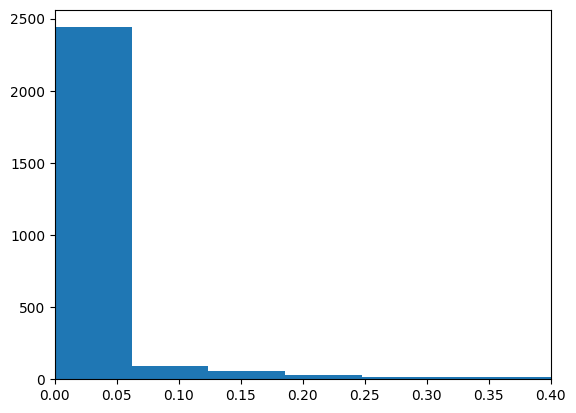

In [298]:
import matplotlib.pyplot as plt
plt.hist(data["mindistancefromhubLCC"],bins=50)
plt.xlim(0,0.4)

In [308]:
quantile_bins = pd.qcut(data["mindistancefromhubLCC"]*1000000000, q=3, retbins=True, duplicates='drop')[1]
quantile_bins

array([0.00000000e+00, 1.72620329e+06, 3.09481692e+09])

In [302]:
len(data["mindistancefromhubLCC"].unique())

1364

In [281]:
quantile_bins = pd.qcut(data[quantile_bins = pd.qcut(data[data.columns], q=4, retbins=True, duplicates='drop')[1]], q=4, retbins=True, duplicates='drop')[1]

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2914886311.py, line 1)

In [ ]:
data.columns

Index(['market', 'airlineAA', 'airlineDL', 'airlineUA', 'airlineAL',
       'airlineLCC', 'airlineWN', 'marketdistance', 'fromcenterdistance',
       'mindistance', 'changeincmarket', 'percapitaincmarket', 'marketsize',
       'wrightamendmDAL', 'dallasmarket', 'marketpresenceAA',
       'marketpresenceDL', 'marketpresenceUA', 'marketpresenceAL',
       'marketpresenceLCC', 'marketpresenceWN', 'mindistancefromhubAA',
       'mindistancefromhubDL', 'mindistancefromhubUA', 'mindistancefromhubAL',
       'mindistancefromhubLCC', 'mindistancefromhubWN'],
      dtype='object')

In [237]:
colname = f"{columns}{carrier}" 
colname

'mindistancefromhubWN'

In [ ]:


# 平均（標準偏差）形式に整形
summary_formatted = summary.copy()
for col in summary.columns.levels[0]:
    summary_formatted[col] = summary[col].apply(lambda x: f"{x['mean']:.3f} ({x['std']:.3f})", axis=1)

# 列を整理
summary_formatted = summary_formatted[[col for col in summary.columns.levels[0]]]


In [220]:

for col in summary.columns.levels[0]:
    summary_formatted[col] = summary[col].apply(lambda x: f"{x['mean']:.3f} ({x['std']:.3f})", axis=1)

AttributeError: 'Index' object has no attribute 'levels'

In [211]:
data = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta")

precense = [
    "marketpresenceAA",
    "marketpresenceDL",
    "marketpresenceUA",
    "marketpresenceL",
    "mindistancefromhubLCC",
    "mindistancefromhubWN"
]

cost = [
    "mindistancefromhubAA",
    "mindistancefromhubDL",
    "mindistancefromhubUA",
    "mindistancefromhubAL",
    "mindistancefromhubLCC",
    "mindistancefromhubWN"
]




data[cost]




,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN
0,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919
1,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336
2,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732
3,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559
4,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2737,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197
2738,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607
2739,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454
2740,1.719620,0.021901,1.719620,0.253380,0.001650,1.388492


In [9]:
data = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta")
y_cols = ['airlineAA', 'airlineDL', 'airlineUA', 'airlineAL', 'airlineLCC', 'airlineWN']
data['entry_vector'] = data[y_cols].apply(tuple, axis=1)
data = data.drop(y_cols,axis=1)
data

,market,marketdistance,fromcenterdistance,mindistance,changeincmarket,percapitaincmarket,marketsize,wrightamendmDAL,dallasmarket,marketpresenceAA,...,marketpresenceAL,marketpresenceLCC,marketpresenceWN,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN,entry_vector
0,ABEATL,0.692,1.343002,0.335306,3.25,3.195271,1.816543,0.0,0.0,0.180000,...,0.480303,0.106667,0.000000,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,ABEBNA,0.685,1.141123,0.335306,3.20,3.085657,1.001007,0.0,0.0,0.203704,...,0.488636,0.000000,0.212963,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
2,ABECVG,0.503,1.226692,0.335306,2.45,3.070847,1.232561,0.0,0.0,0.038462,...,0.363636,0.000000,0.000000,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,ABEDAL,1.300,1.333661,0.114112,3.00,3.228897,2.002419,1.0,1.0,0.042857,...,0.363636,0.000000,0.414286,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,ABEDEN,1.539,1.598928,0.335306,4.10,3.491519,1.374757,0.0,0.0,0.278169,...,0.504481,0.080986,0.000000,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,TPATRI,0.586,1.341580,0.102310,4.15,2.580612,0.667070,0.0,0.0,0.204724,...,0.220472,0.090551,0.157480,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2738,TPATUL,0.965,1.130021,0.102310,6.55,3.035730,1.456809,0.0,0.0,0.628967,...,0.278991,0.090551,0.437783,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607,"(1.0, 1.0, 0.0, 1.0, 0.0, 1.0)"
2739,TPATUS,1.721,2.029194,0.102310,4.20,2.708500,1.450960,0.0,0.0,0.509072,...,0.358211,0.090551,0.287915,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454,"(1.0, 1.0, 0.0, 1.0, 0.0, 1.0)"
2740,TPATYS,0.547,1.271215,0.102310,3.75,2.838343,1.235865,0.0,0.0,0.230365,...,0.271755,0.090551,0.157480,1.719620,0.021901,1.719620,0.253380,0.001650,1.388492,"(0.0, 1.0, 0.0, 1.0, 0.0, 0.0)"


In [15]:
data = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta")
data

,market,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN,marketdistance,fromcenterdistance,mindistance,...,marketpresenceUA,marketpresenceAL,marketpresenceLCC,marketpresenceWN,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN
0,ABEATL,0.0,1.0,0.0,0.0,0.0,0.0,0.692,1.343002,0.335306,...,0.246364,0.480303,0.106667,0.000000,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919
1,ABEBNA,0.0,0.0,0.0,1.0,0.0,0.0,0.685,1.141123,0.335306,...,0.205808,0.488636,0.000000,0.212963,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336
2,ABECVG,0.0,0.0,0.0,0.0,0.0,0.0,0.503,1.226692,0.335306,...,0.219697,0.363636,0.000000,0.000000,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732
3,ABEDAL,0.0,0.0,0.0,0.0,0.0,0.0,1.300,1.333661,0.114112,...,0.136364,0.363636,0.000000,0.414286,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559
4,ABEDEN,0.0,0.0,1.0,1.0,0.0,0.0,1.539,1.598928,0.335306,...,0.470871,0.504481,0.080986,0.000000,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,TPATRI,0.0,1.0,0.0,0.0,0.0,0.0,0.586,1.341580,0.102310,...,0.160236,0.220472,0.090551,0.157480,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197
2738,TPATUL,1.0,1.0,0.0,1.0,0.0,1.0,0.965,1.130021,0.102310,...,0.208721,0.278991,0.090551,0.437783,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607
2739,TPATUS,1.0,1.0,0.0,1.0,0.0,1.0,1.721,2.029194,0.102310,...,0.247917,0.358211,0.090551,0.287915,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454
2740,TPATYS,0.0,1.0,0.0,1.0,0.0,0.0,0.547,1.271215,0.102310,...,0.148698,0.271755,0.090551,0.157480,1.719620,0.021901,1.719620,0.253380,0.001650,1.388492


In [109]:
data["ending_point"] = data['market'].str[3:]
data

,market,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN,marketdistance,fromcenterdistance,mindistance,...,marketpresenceLCC,marketpresenceWN,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN,starting_point,ending_point
0,ABEATL,0.0,1.0,0.0,0.0,0.0,0.0,0.692,1.343002,0.335306,...,0.106667,0.000000,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919,ABE,ATL
1,ABEBNA,0.0,0.0,0.0,1.0,0.0,0.0,0.685,1.141123,0.335306,...,0.000000,0.212963,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336,ABE,BNA
2,ABECVG,0.0,0.0,0.0,0.0,0.0,0.0,0.503,1.226692,0.335306,...,0.000000,0.000000,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732,ABE,CVG
3,ABEDAL,0.0,0.0,0.0,0.0,0.0,0.0,1.300,1.333661,0.114112,...,0.000000,0.414286,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559,ABE,DAL
4,ABEDEN,0.0,0.0,1.0,1.0,0.0,0.0,1.539,1.598928,0.335306,...,0.080986,0.000000,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000,ABE,DEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,TPATRI,0.0,1.0,0.0,0.0,0.0,0.0,0.586,1.341580,0.102310,...,0.090551,0.157480,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197,TPA,TRI
2738,TPATUL,1.0,1.0,0.0,1.0,0.0,1.0,0.965,1.130021,0.102310,...,0.090551,0.437783,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607,TPA,TUL
2739,TPATUS,1.0,1.0,0.0,1.0,0.0,1.0,1.721,2.029194,0.102310,...,0.090551,0.287915,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454,TPA,TUS
2740,TPATYS,0.0,1.0,0.0,1.0,0.0,0.0,0.547,1.271215,0.102310,...,0.090551,0.157480,1.719620,0.021901,1.719620,0.253380,0.001650,1.388492,TPA,TYS


In [187]:
data = pd.read_stata("/Users/user/Desktop/replication/5368_data and programs_0/CilibertoTamerEconometrica.dta")

carrier = ['airlineAA', 'airlineDL', 'airlineUA', 'airlineAL', 'airlineLCC', 'airlineWN']

#precenseの計算のために始点を追加
data["starting_point"] = data['market'].str[:3]
starting_point = data["starting_point"].unique()

#precenseの計算のために終点を追加
data["ending_point"] = data['market'].str[3:]
ending_point = data["ending_point"].unique()

#startのprecenseを計算
#各starting_pointごとにprecenseを計算し,df:precense_startを作成

precense_start = pd.DataFrame()

for i in starting_point:
    market_data = data[data["starting_point"]==i][carrier]
    total_entry_bycarrier = market_data.sum()
    #総数は少なくとも１社以上入っている市場（元論文参照）
    market_number = (market_data != 0).any(axis=1).sum()
    precense_market = (total_entry_bycarrier / market_number).reset_index()
    precense_market["starting_point"] = i
    precense_start = pd.concat([precense_start,precense_market])

precense_start.columns = ["carrier", "precense_start","starting_point"]


#endのprecenseを計算
#各ending_pointごとにprecenseを計算し,df:precense_endを作成

precense_end = pd.DataFrame()

for i in ending_point:
    market_data = data[data["ending_point"]==i][carrier]
    total_entry_bycarrier = market_data.sum()
    #総数は少なくとも１社以上入っている市場（元論文参照）
    market_number = (market_data != 0).any(axis=1).sum()
    precense_market = (total_entry_bycarrier / market_number).reset_index()
    precense_market["starting_point"] = i
    precense_end = pd.concat([precense_end,precense_market])


precense_end.columns = ["carrier", "precense_end","ending_point"]


#preceseの平均値を取るためにmergeする
data_start = pd.merge(data[["market","starting_point","ending_point"]],precense_start,on="starting_point")
start_end = pd.merge(data_start,precense_end,on=["ending_point","carrier"])
start_end["precense"] = (start_end["precense_start"]+start_end["precense_end"])/2

#元データと接合する


In [197]:
start_end

,market,starting_point,ending_point,carrier,precense_start,precense_end,precense
0,ABEATL,ABE,ATL,airlineAA,0.000000,0.250000,0.125000
1,ABEATL,ABE,ATL,airlineDL,0.400000,1.000000,0.700000
2,ABEATL,ABE,ATL,airlineUA,0.266667,0.000000,0.133333
3,ABEATL,ABE,ATL,airlineAL,0.866667,0.500000,0.683333
4,ABEATL,ABE,ATL,airlineLCC,0.000000,0.250000,0.125000
...,...,...,...,...,...,...,...
16447,TULTUS,TUL,TUS,airlineDL,0.000000,0.400000,0.200000
16448,TULTUS,TUL,TUS,airlineUA,0.000000,0.290909,0.145455
16449,TULTUS,TUL,TUS,airlineAL,0.000000,0.690909,0.345455
16450,TULTUS,TUL,TUS,airlineLCC,0.000000,0.072727,0.036364


In [168]:

total_number_bycarrier = data[data["starting_point"]=="ABE"][carrier].sum()
total_number = total_number_bycarrier.sum()
precense_market = (total_number_bycarrier / total_number).reset_index()
precense_market["starting_point"] = "ABE"
precense_start = pd.concat([precense_start,precense_market])

In [193]:
total_entry_bycarrier = market_data.sum()
    #総数は少なくとも１社以上入っている市場（元論文参照）
    # market_number = (market_data != 0).any(axis=1).sum()

In [196]:
(market_data != 0).any(axis=1).sum()

7

In [195]:
market_data

,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN
643,1.0,0.0,0.0,0.0,0.0,0.0
1201,0.0,0.0,0.0,0.0,0.0,0.0
1368,0.0,0.0,1.0,0.0,0.0,0.0
1435,1.0,0.0,0.0,0.0,0.0,0.0
1785,0.0,0.0,0.0,0.0,0.0,0.0
1962,1.0,0.0,0.0,0.0,0.0,0.0
2018,1.0,0.0,0.0,0.0,0.0,0.0
2476,1.0,0.0,1.0,0.0,0.0,0.0
2538,0.0,0.0,1.0,0.0,0.0,0.0


In [194]:
market_data.sum()

airlineAA     5.0
airlineDL     0.0
airlineUA     3.0
airlineAL     0.0
airlineLCC    0.0
airlineWN     0.0
dtype: float32

In [176]:
A = data[data["starting_point"]=="ABE"][carrier]
A = A.loc[(A != 0).any(axis=1)]
A

,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,0.0
6,0.0,1.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,1.0,0.0,0.0
10,0.0,0.0,0.0,1.0,0.0,0.0
11,0.0,1.0,0.0,1.0,0.0,0.0


In [188]:
pivot_start_end = start_end.pivot_table(index="market", 
                         columns="carrier", 
                         values="precense").reset_index()

In [202]:
data["mindistancefromhubDL"].mean()
"from_centerdistance"
min

0.42000312

In [192]:
pivot_start_end["airlineUA"].mean()

0.28803226

In [166]:
pivot_start_end["airlineDL"].mean()

0.26903787

In [132]:

start_end.groupby("carrier")["precense"].mean()

carrier
airlineAA     0.181369
airlineAL     0.251348
airlineDL     0.269038
airlineLCC    0.072813
airlineUA     0.111415
airlineWN     0.114017
Name: precense, dtype: float32

In [101]:
data[["market","starting_point"]]
A = pd.merge(data[["market","starting_point"]],precense,on="starting_point")
A.groupby("carrier")["share"].mean()

carrier
airlineAA     0.179245
airlineAL     0.251000
airlineDL     0.265911
airlineLCC    0.071748
airlineUA     0.111804
airlineWN     0.120291
Name: share, dtype: float32

In [83]:
precense.groupby(["carrier"])

KeyError: 'carrier'

In [73]:
df = pd.DataFrame()
df = pd.concat([df,precense])
df = pd.concat([df,precense])
df


,index,0,starting_point
0,airlineAA,0.000000,ABE
1,airlineDL,0.260870,ABE
2,airlineUA,0.173913,ABE
3,airlineAL,0.565217,ABE
4,airlineLCC,0.000000,ABE
5,airlineWN,0.000000,ABE
0,airlineAA,0.000000,ABE
1,airlineDL,0.260870,ABE
2,airlineUA,0.173913,ABE
3,airlineAL,0.565217,ABE


In [35]:
data["starting_poin"] = data['market'].str[:3]
data

,market,airlineAA,airlineDL,airlineUA,airlineAL,airlineLCC,airlineWN,marketdistance,fromcenterdistance,mindistance,...,marketpresenceAL,marketpresenceLCC,marketpresenceWN,mindistancefromhubAA,mindistancefromhubDL,mindistancefromhubUA,mindistancefromhubAL,mindistancefromhubLCC,mindistancefromhubWN,starting_poin
0,ABEATL,0.0,1.0,0.0,0.0,0.0,0.0,0.692,1.343002,0.335306,...,0.480303,0.106667,0.000000,0.818320,0.000000,0.818320,0.020990,0.000000,0.006919,ABE
1,ABEBNA,0.0,0.0,0.0,1.0,0.0,0.0,0.685,1.141123,0.335306,...,0.488636,0.000000,0.212963,0.549801,0.067416,0.549801,0.040935,0.038202,0.032336,ABE
2,ABECVG,0.0,0.0,0.0,0.0,0.0,0.0,0.503,1.226692,0.335306,...,0.363636,0.000000,0.000000,0.822086,0.000000,0.822086,0.008663,0.113940,0.092732,ABE
3,ABEDAL,0.0,0.0,0.0,0.0,0.0,0.0,1.300,1.333661,0.114112,...,0.363636,0.000000,0.414286,0.012455,0.003560,0.115493,0.007775,0.012372,0.020559,ABE
4,ABEDEN,0.0,0.0,1.0,1.0,0.0,0.0,1.539,1.598928,0.335306,...,0.504481,0.080986,0.000000,0.000000,0.018033,0.000000,0.000000,0.000000,0.000000,ABE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,TPATRI,0.0,1.0,0.0,0.0,0.0,0.0,0.586,1.341580,0.102310,...,0.220472,0.090551,0.157480,1.548052,0.081340,1.548052,0.072723,0.001893,1.060197,TPA
2738,TPATUL,1.0,1.0,0.0,1.0,0.0,1.0,0.965,1.130021,0.102310,...,0.278991,0.090551,0.437783,0.206302,0.118204,0.655474,0.259594,0.000000,0.277607,TPA
2739,TPATUS,1.0,1.0,0.0,1.0,0.0,1.0,1.721,2.029194,0.102310,...,0.358211,0.090551,0.287915,0.009548,0.009548,0.244937,0.000000,0.000000,0.000454,TPA
2740,TPATYS,0.0,1.0,0.0,1.0,0.0,0.0,0.547,1.271215,0.102310,...,0.271755,0.090551,0.157480,1.719620,0.021901,1.719620,0.253380,0.001650,1.388492,TPA


In [349]:
import numpy as np

def makeindex(k):
    total = 2 ** k
    index = np.zeros((total, k), dtype=int)

    for i in range(k):
        ii = 0
        cc = 1
        c = total // (2 ** (i + 1))
        while ii < total:
            if cc <= c:
                index[ii, i] = 1
                cc += 1
                ii += 1
            else:
                ii += c
                cc = 1

    return index